In [121]:
%matplotlib inline

import librosa
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
from tslearn.barycenters import dtw_barycenter_averaging

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [122]:
import pydub
from pydub import AudioSegment, effects  

In [123]:
for i in range(1,11):
    rawsound = AudioSegment.from_file(f"cluster{i}.wav", "wav")  
    normalizedsound = effects.normalize(rawsound)  
    normalizedsound.export(f"./normalize_cluster_{i}.wav", format="wav")

In [124]:
rawsound = AudioSegment.from_file("KT-XH02-3.wav", "wav")  
normalizedsound = effects.normalize(rawsound)  
normalizedsound.export("./KT-XH02-3-normalize.wav", format="wav")

<_io.BufferedRandom name='./KT-XH02-3-normalize.wav'>

In [125]:
ts_set = []
for i in range(1,3):
    x_2, fs = librosa.load(f'normalize_cluster_{i}.wav')
    ts_set.append(x_2)    

In [146]:
x_1, fs = librosa.load('KT-XH02-COMBINE-normalize.wav')
x_2 = dtw_barycenter_averaging(ts_set, max_iter=5).reshape(-1)


In [147]:
x_1.shape

(15812736,)

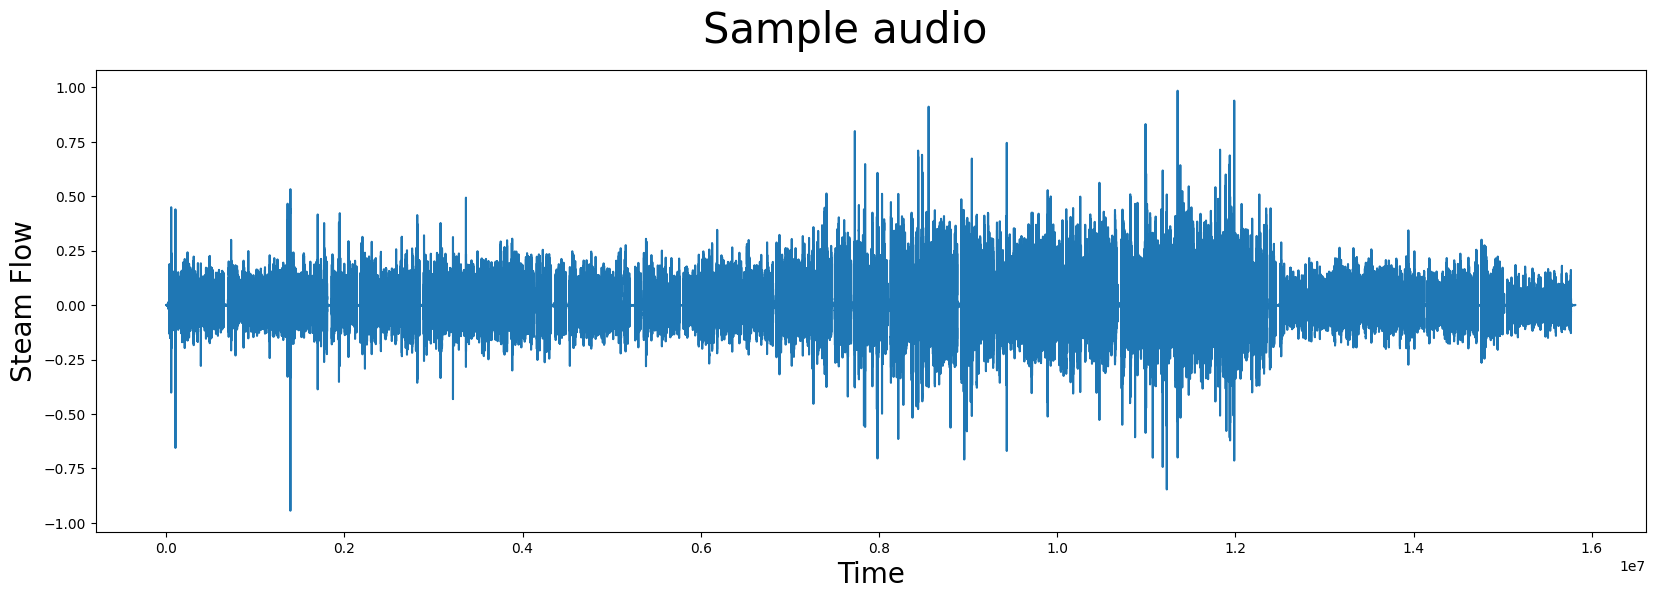

In [148]:
plt.suptitle('Sample audio', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(x_1)
plt.show()

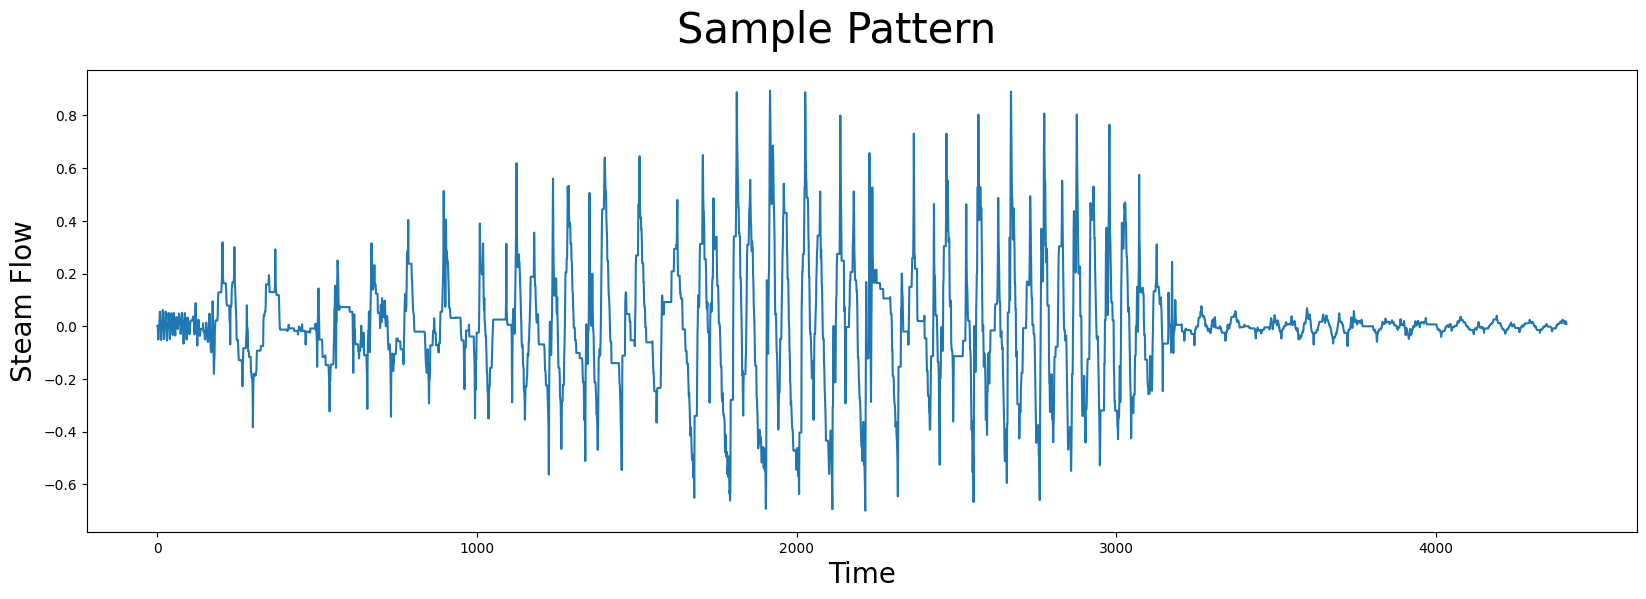

In [149]:
plt.suptitle('Sample Pattern', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(x_2)
plt.show()

In [151]:
matches= stumpy.match(x_2.astype(np.float64), x_1.astype(np.float64),max_distance= lambda D: max(np.mean(D) - 5*np.std(D), np.min(D)),  max_matches=111, normalize=True)

In [152]:
lcs = matches[:,1]
lcs = np.sort(lcs)
lcs

array([98350, 156345, 324135, 398079, 466459, 643860, 776771, 866616,
       930703, 987992, 1196417, 1229107, 1486406, 1517066, 1642470,
       1857731, 1933802, 1960891, 2134553, 2330016, 2418879, 2603910,
       2660156, 2837801, 3027632, 3213341, 3396293, 3510229, 3559321,
       3643332, 3849549, 4089314, 4316652, 4374826, 4595532, 4638473,
       4689413, 4806386, 4927356, 4997060, 5567079, 5945355, 6156249,
       6413158, 6508396, 6629950, 6642209, 6702270, 6864468, 6880852,
       7045455, 7372012, 7683684, 7866041, 7943270, 8071043, 8298791,
       8396290, 8546590, 8561028, 8782169, 8841586, 9024186, 9751891,
       9824107, 10009852, 10245120, 10317275, 10678103, 10954873,
       11568428, 11636575, 11713891, 11880018, 11972570, 12118388,
       12448026, 12579481, 12799683, 13065831, 13110553, 13183892,
       13669889, 13701676, 13818211, 13876679, 13996719, 14026527,
       14040903, 14114467, 14199001, 14324021, 14502218, 14515192,
       14612490, 14671822, 14717298, 1

In [153]:
matches[:,0][1]

54.882194752122075

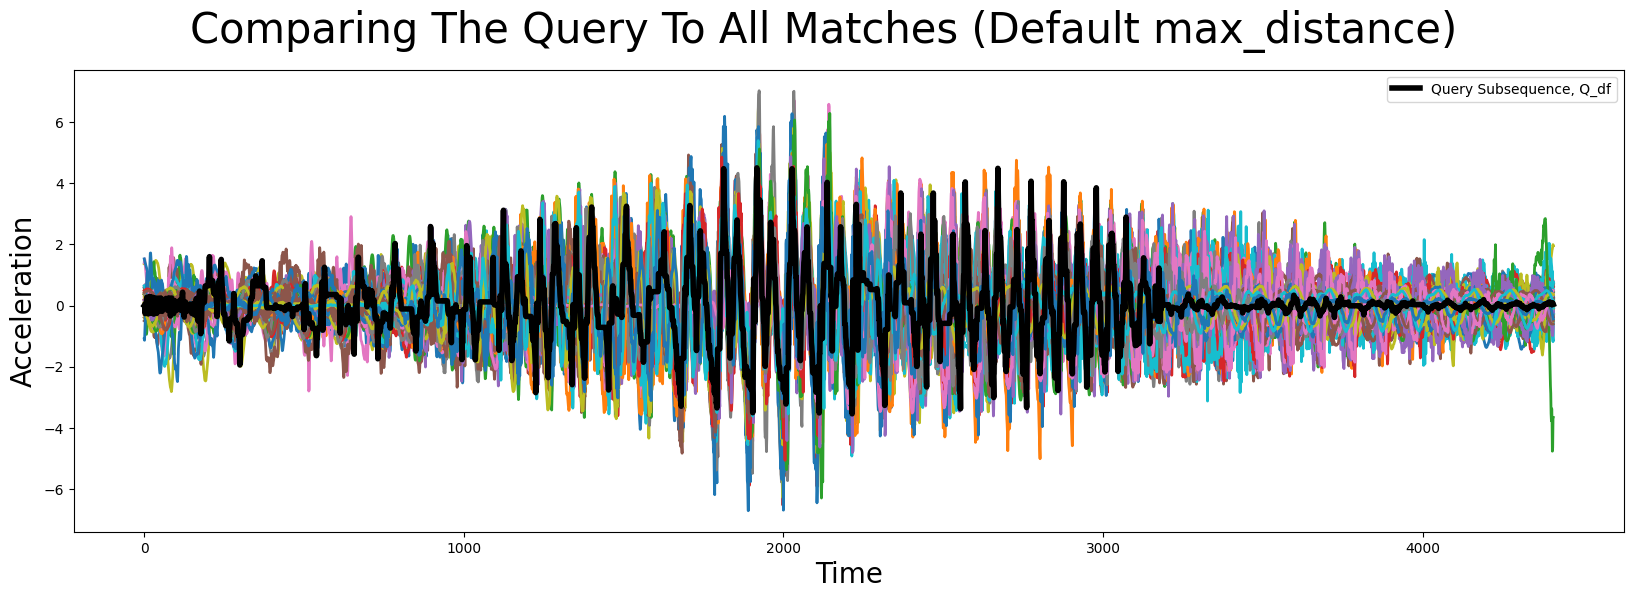

In [154]:
Q_z_norm = stumpy.core.z_norm(x_2)

plt.suptitle('Comparing The Query To All Matches (Default max_distance)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
for match_distance, match_idx in matches:
    match_z_norm = stumpy.core.z_norm(x_1[match_idx:match_idx+len(x_2)])
    plt.plot(match_z_norm, lw=2)
plt.plot(Q_z_norm, lw=4, color="black", label="Query Subsequence, Q_df")
plt.legend()
plt.show()

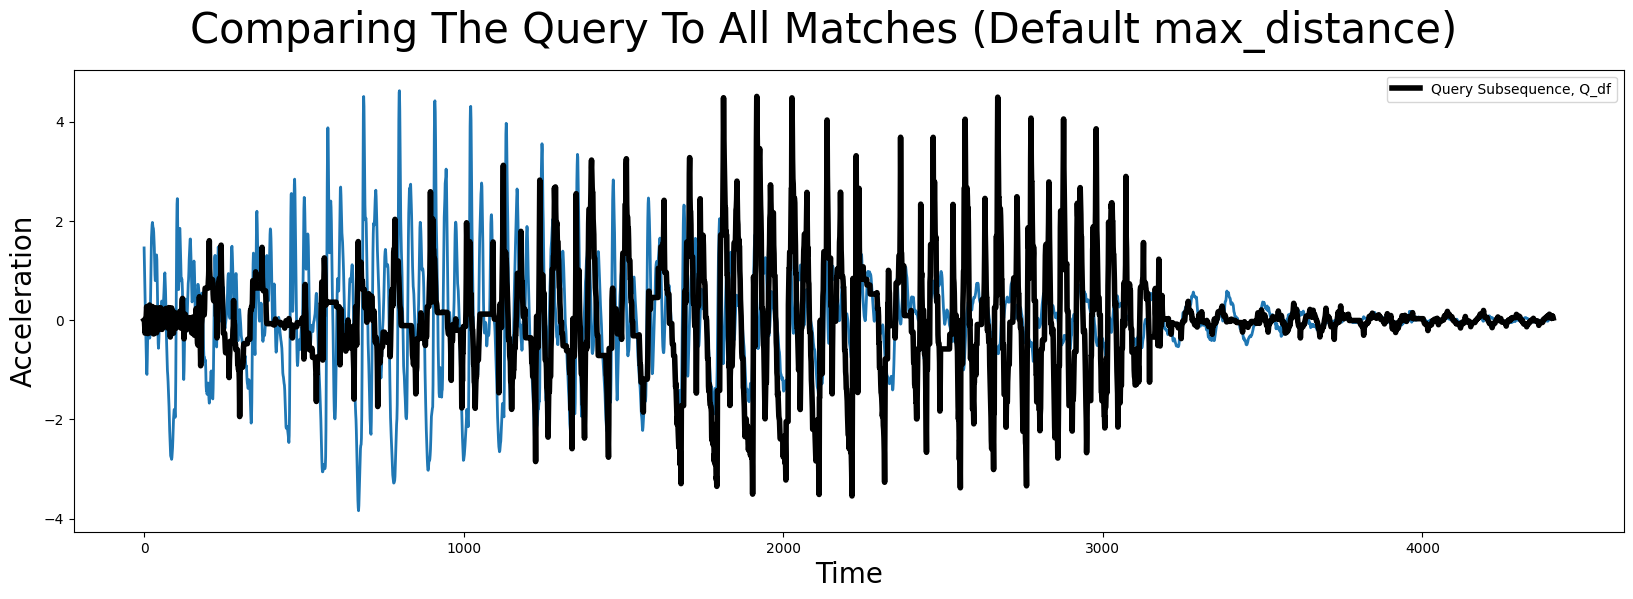

In [155]:
Q_z_norm = stumpy.core.z_norm(x_2)

plt.suptitle('Comparing The Query To All Matches (Default max_distance)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')

match_z_norm = stumpy.core.z_norm(x_1[249081:249081+len(x_2)])
plt.plot(match_z_norm, lw=2)
plt.plot(Q_z_norm, lw=4, color="black", label="Query Subsequence, Q_df")
plt.legend()
plt.show()

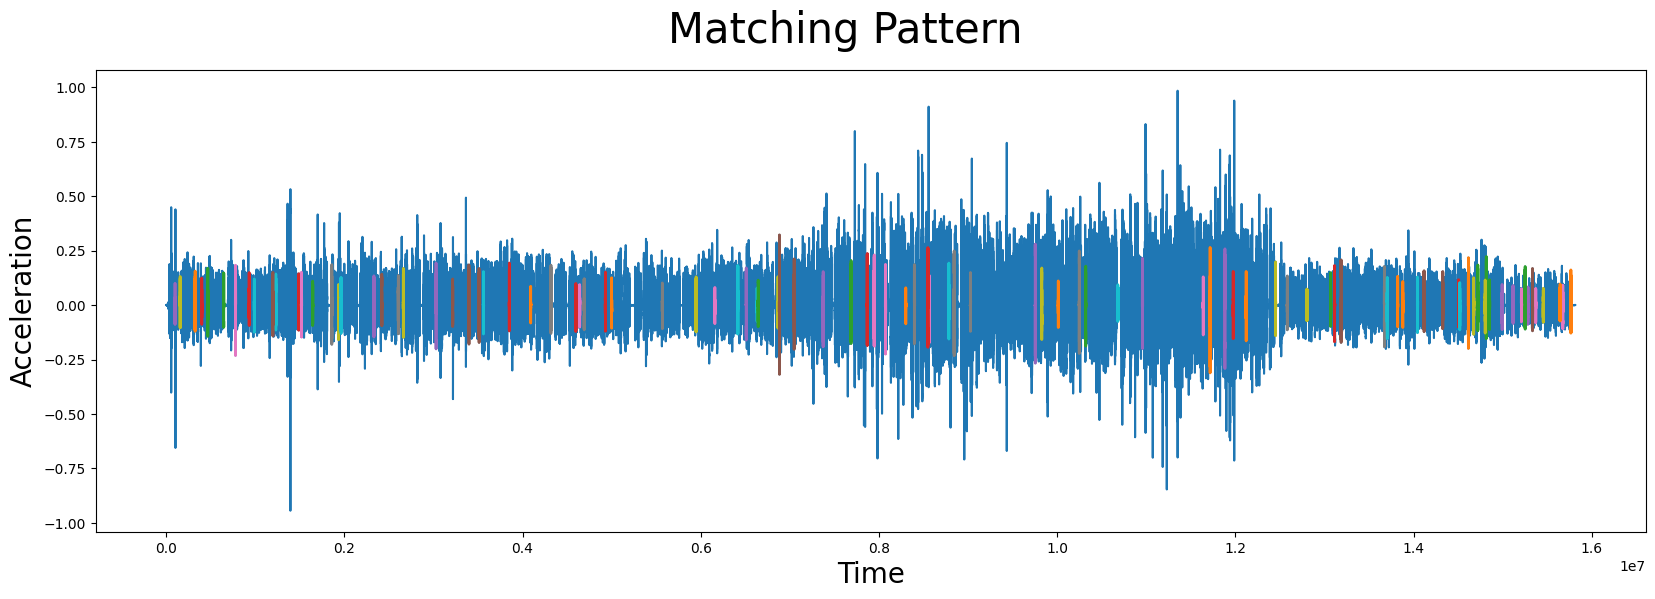

In [156]:
plt.suptitle('Matching Pattern', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(x_1)
for idx in matches[:,1]:
    plt.plot(range(idx, idx+len(x_2)), x_1[idx:idx+len(x_2)], lw=2, label="Nearest Neighbor Subsequence")
#plt.legend()
plt.show()

In [157]:
from dtaidistance import dtw


def cast_vector(row):
    return np.array(list(map(lambda x: x.astype('double'), row)))

def distance_profile(Q, T):
    Q = Q.copy()
    T = T.copy()
    n = len(T)
    m = len(Q)
    naive_distance_profile = np.empty(len(lcs))
  

    Q = stumpy.core.z_norm(Q)
    Q = cast_vector(Q)
    for i in range(len(lcs)):
        new_T = cast_vector(stumpy.core.z_norm(T[lcs[i]:lcs[i]+m]))
        distance = dtw.distance_fast(Q, new_T, use_pruning=True)  
        naive_distance_profile[i] = distance


    return naive_distance_profile

In [158]:
naive_distance_profile = distance_profile(x_2, x_1)

In [159]:
naive_distance_profile

array([26.69874297, 18.66471016, 15.65576503, 23.09128443, 25.73965531,
       14.85784865, 22.01226136, 21.32970534, 24.16268201, 26.80043686,
       23.11133103, 19.17335515, 16.30575049, 18.04657441, 19.29126287,
       25.96317735, 31.93159871, 26.93173289, 18.04555045, 20.71074901,
       20.72199833, 21.71668821, 17.33844632, 16.58557256, 29.9027812 ,
       19.17556992, 19.29678887, 19.92457992, 31.88374275, 20.0091032 ,
       17.49185366, 37.75781578, 17.57414153, 38.8084847 , 24.08021809,
       22.09562971, 22.46794448, 29.98060256, 18.13402342, 31.02223749,
       31.33538361, 21.76948212, 27.89153885, 15.97686146, 19.0378566 ,
       35.34446035, 25.50169859, 37.37492971, 45.26894752, 23.57487118,
       19.73900653, 23.29525178, 17.97473719, 17.38536646, 16.45426021,
       26.15694184, 35.2910506 , 22.45049834, 16.80044276, 27.46263726,
       34.48852845, 18.93564575, 38.47370406, 21.56222368, 19.91821083,
       30.59640525, 20.51350892, 26.7360817 , 16.45441146, 19.74

In [160]:
dict_ = {}
for i in range(len(lcs)):
    dict_[lcs[i]]  = (2*naive_distance_profile[i]*matches[:,0][i])/(naive_distance_profile[i] + matches[:,0][i])
    dict_[lcs[i]] = naive_distance_profile[i]
    
sorted_dict = sorted(dict_.items(), key=lambda x:x[1])


In [161]:
sorted_dict[:11]

[(643860, 14.857848654013019),
 (324135, 15.655765034665865),
 (6413158, 15.976861462862864),
 (1486406, 16.305750487978848),
 (7943270, 16.454260213316722),
 (10678103, 16.45441145657862),
 (2837801, 16.5855725590392),
 (8546590, 16.800442760652228),
 (13818211, 16.89518967408923),
 (13065831, 16.997712608059146),
 (11568428, 17.13667004298101)]

In [162]:
def distance_profile_equal(Q, T):
    Q = Q.copy()
    T = T.copy()

  

    Q = stumpy.core.z_norm(Q)
    Q = cast_vector(Q)
 
    new_T = cast_vector(stumpy.core.z_norm(T))
    distance = dtw.distance_fast(Q, new_T, use_pruning=True)  
    naive_distance_profile = distance


    return naive_distance_profile

In [163]:
trace = []
mean_dtw = []
new_dict = {}
for j in range(len(sorted_dict)//2):
    x_1_new = x_1[sorted_dict[j][0] : sorted_dict[j][0]+len(x_2)]

    for i in range(1, 10):
        x_2_new, fs = librosa.load(f'normalize_cluster_{i}.wav')
        naive_distance_profile = distance_profile_equal(x_2_new, x_1_new)
        trace.append(naive_distance_profile)
    #print(len(trace))
    mean_dtw.append(sum(trace)/10)
    trace = []
    
for i in range(len(sorted_dict)//2):
    
    new_dict[sorted_dict[i][0]] = mean_dtw[i]
    
new_sorted_dict = sorted(new_dict.items(), key=lambda x:x[1])
new_sorted_dict

[(2837801, 10.895315745431327),
 (643860, 11.076670846888362),
 (7943270, 11.22044387923118),
 (2660156, 11.353261132896796),
 (2134553, 11.4091020569272),
 (1486406, 11.45139751050178),
 (324135, 11.470292953153951),
 (14324021, 11.574815334811397),
 (13065831, 11.621995135087303),
 (15762445, 11.926558606641374),
 (13818211, 12.007431364716542),
 (4927356, 12.227170067856912),
 (11568428, 12.268287232281098),
 (1229107, 12.447315475526613),
 (4316652, 12.46794855172237),
 (7683684, 12.671807517769672),
 (3849549, 12.69972862678884),
 (10678103, 12.782620199699526),
 (6413158, 12.812000531512785),
 (14717298, 13.307542117713647),
 (3213341, 13.417711273703924),
 (1642470, 13.508622299344472),
 (7866041, 13.7260384236819),
 (12799683, 13.755024399168814),
 (1517066, 14.034635653006797),
 (156345, 14.047878697761828),
 (15452449, 14.080688372932315),
 (10954873, 14.127668204844449),
 (8546590, 14.183046125657203),
 (15278611, 14.230819734602164),
 (15112807, 14.343428945306547),
 (14199

In [176]:
idx_ = []

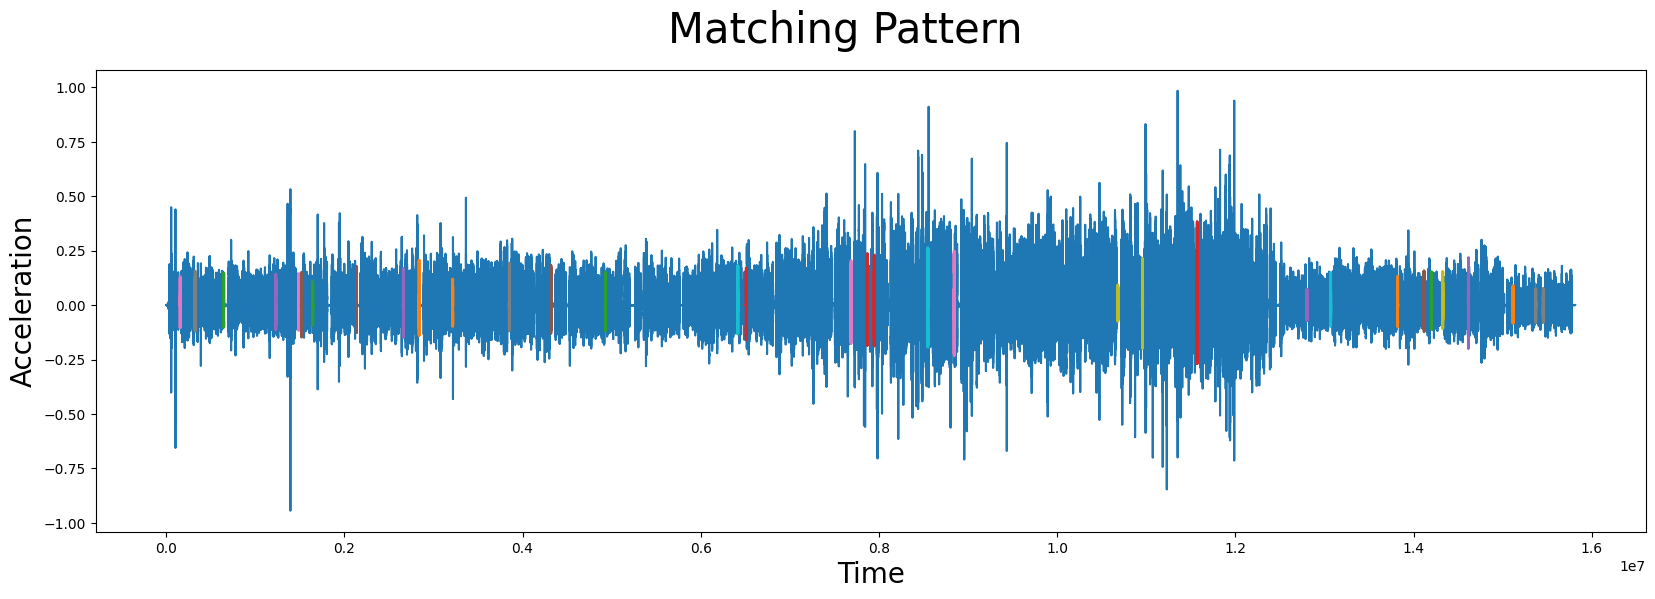

In [177]:
nums = 37
plt.suptitle('Matching Pattern', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(x_1)
for idx in range(nums):
    idx_.append(new_sorted_dict[idx][0])
    #print(new_sorted_dict[idx][1], new_sorted_dict[idx][0])
    plt.plot(range(new_sorted_dict[idx][0], new_sorted_dict[idx][0]+len(x_2)), x_1[new_sorted_dict[idx][0]:new_sorted_dict[idx][0]+len(x_2)], lw=2, label="Nearest Neighbor Subsequence")
#plt.legend()
plt.show()

In [179]:
idx_ = np.sort(idx_)

In [180]:
idx_

array([  156345,   324135,   643860,  1229107,  1486406,  1517066,
        1642470,  2134553,  2660156,  2837801,  3213341,  3849549,
        4316652,  4927356,  6413158,  6508396,  7683684,  7866041,
        7943270,  8546590,  8841586, 10678103, 10954873, 11568428,
       12799683, 13065831, 13818211, 14114467, 14199001, 14324021,
       14612490, 14717298, 15112807, 15278611, 15367276, 15452449,
       15762445], dtype=int64)